# 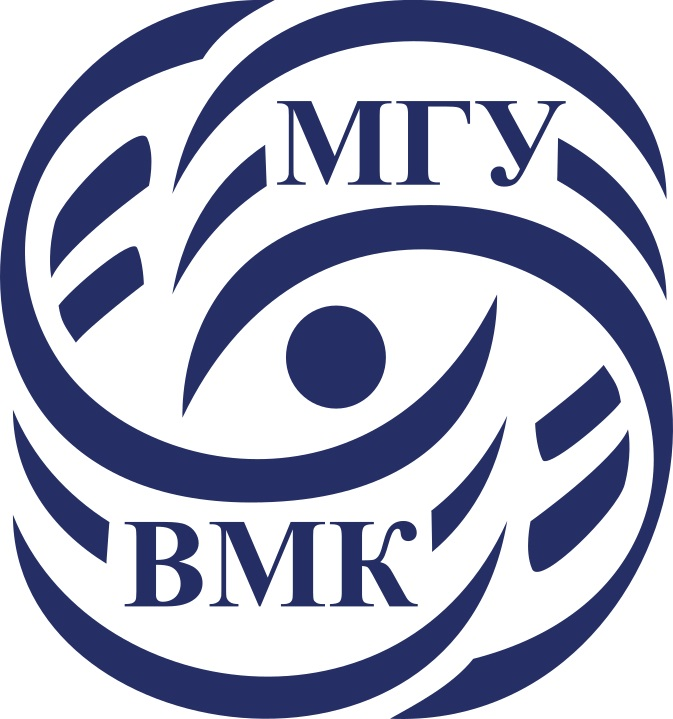

# Машинное обучение. ВМК МГУ

# Практическое задание 7: SVM
## Уровень: <font color='SkyBlue'>**Базовый (Base)**</font>

# О формате сдачи

🔷 **<font color='plum'>При решении ноутбука используйте данный шаблон</font>**

    ✅ Можно добавлять новые ячейки любых типов
    ❌ Не нужно удалять текстовые ячейки c разметкой частей ноутбука и формулировками заданий


🔷 **<font color='plum'>При оценивании задач учитывается код</font>**

    ✅ Задания, в которых необходим код, обычно помечаются фразами "Your code here"/"Ваш код" и аналогичными
    ❌ Ответы на вопросы без сопутствующего кода оцениваются в 0 баллов
    ❌ Наличе работоспособного кода в ноутбуке, если на сказано иного, обязательно

🔷 **<font color='plum'>При оценивании задач учитываются выводы</font>**

    ✅ Задания, в которых необходимы выводы, обычно помечаются фразами Вывод"/"Ответ на вопрос"/"Ваш текст" и аналогичными
    ✅ Обычно выводы подразумевают под собой текстовый ответ (можно писать markdown, latex).
    ✅ Сопутствующие изображения, графики, таблички - приветствуются!
    ❌ При отсутствии выводов задание не засчитается на полный балл

Цель данного задания:

* Изучите работу модели SVM
* Поймете, как с её помощью можно строить нелинейные разделяющие поверхности
* Потренируетесь в подборе оптимальных параметров на обучающей выборке для достижения наилучшего качества на закрытой выборке (ML-решение)

-------
<font color="white" style="opacity:0.2024"></font>
<font color=DarkOrange>**Примерное время выполнения (execution time/время выполнения, если нажать run all) всех ячеек ноутбука при правильной реализации: до 10 минут </font>**

# Подготовка рабочей среды

Сначала установим нужные нам версии библиотек. Мы гарантируем, что в данных версиях задание будет корректно отрабатывать.

После установки нужных версий, **возможно,** нужно перезагрузить среду (runtime), но скорее всего вам это не понадобится


На скачивание файла и установку понадобится не более 5 минут.

<font color='OrangeRed'>**Важно!**</font>

Устанавливать нужные версии нужно каждый раз, когда создается новый рантайм. Например, если вы 2 часа подряд делаете это задание, то подготовить библиотеки достаточно 1 раз. Но если вы, например, начали в понедельник, затем закрыли/выключили ноутбук, то при продолжении в среду, вам нужно будет запустить рантайм заново и следовательно заново установить библиотеки.

<font color='OrangeRed'>**Важно!**</font>
Если вы предпочитаете делать практические задания на своем личном ноутбуке, то проверьте, что вы установили рабочее окружение в [соответствии с гайдом](https://github.com/MSU-ML-COURSE/ML-COURSE-24-25/blob/main/tutorials/%D0%A2%D1%83%D1%82%D0%BE%D1%80%D0%B8%D0%B0%D0%BB%20%D0%BF%D0%BE%20%D1%83%D1%81%D1%82%D0%B0%D0%BD%D0%BE%D0%B2%D0%BA%D0%B5%20%D1%80%D0%B0%D0%B1%D0%BE%D1%87%D0%B5%D0%B3%D0%BE%20%D0%BE%D0%BA%D1%80%D1%83%D0%B6%D0%B5%D0%BD%D0%B8%D1%8F%20%D0%B2%20Python%20%D0%B4%D0%BB%D1%8F%20%D1%80%D0%B5%D1%88%D0%B5%D0%BD%D0%B8%D1%8F%20%D0%B7%D0%B0%D0%B4%D0%B0%D1%87%20(2).pdf)


In [1]:
# !!! Данный блок будет работать только в Google-Colab !!!
! gdown 10k8Hwn9kpK9SpK4IEj4-EaWQZqgYT5-Q
! pip install -r /content/requirements_2024_25_for_colab_small.txt

Downloading...
From: https://drive.google.com/uc?id=10k8Hwn9kpK9SpK4IEj4-EaWQZqgYT5-Q
To: /content/requirements_2024_25_for_colab_small.txt
100% 375/375 [00:00<00:00, 1.77MB/s]


Проверим версию библиотеки:

In [2]:
import catboost
assert(catboost.__version__ == '1.2.7')

Теперь можно приступать к выполнению задания! :)

-----------
<font color="white" style="opacity:0.2023"></font>

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

from copy import copy

Если Вы дальтоник, то можете воспользоваться готовой colormap из matplotlib (или найти свою):
```
plt.style.use('tableau-colorblind10')
```

Приведем вспомогательный код

In [4]:
from matplotlib.colors import ListedColormap

from sklearn.svm import LinearSVC, SVC
from sklearn.decomposition import PCA
from sklearn.model_selection import cross_val_score, cross_val_predict, cross_validate, train_test_split
from sklearn.metrics import make_scorer, accuracy_score, roc_auc_score
from sklearn.datasets import make_blobs, make_circles, make_moons

In [5]:
def make_moons_cls(size=1000, d=2):
    X, y = make_moons(n_samples=size, noise=0.15)
    if d > 2:
        X = np.concatenate((X, np.random.normal(size=(size, d-2))), axis=1)
    return X, y

def make_circles_cls():
    X, y = make_circles()

def generate_data_with_imb_classes(size1=100, size2=10):
    X = np.r_[(
        np.random.normal(loc=1.0, size=(size1, 2)),
        np.random.normal(loc=0.5, size=(size2, 2))
    )]

    y = np.ones(len(X))
    y[-size2:] = 0
    return X, y

In [6]:
def plot_separating_surface(X, y, cls, view_support=False, title=''):
    x_min = min(X[:, 0]) - 0.1
    x_max = max(X[:, 0]) + 0.1
    y_min = min(X[:, 1]) - 0.1
    y_max = max(X[:, 1]) + 0.1
    h = 0.005
    cm = plt.cm.RdBu
    cm_bright = ListedColormap(['#FF0000', '#0000FF'])

    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                             np.arange(y_min, y_max, h))
    Z = cls.predict(np.c_[xx.ravel(), yy.ravel()])

    plt.figure(figsize=(10, 10))
    if title:
        plt.title(title)
    plt.scatter(X[:, 0], X[:, 1], c=y, edgecolors='k', s=40, cmap=cm_bright)
    if view_support:
        plt.scatter(X[cls.support_, 0], X[cls.support_, 1],
                    c=y[cls.support_], edgecolors='k', s=150, cmap=cm_bright)
    Z = Z.reshape(xx.shape)
    plt.xticks(())
    plt.yticks(())
    plt.contourf(xx, yy, Z, cmap=cm, alpha=.3)
    plt.show()

# Загрузка данных

In [7]:
import gdown
gdown.download_folder('https://drive.google.com/drive/folders/1bp39_Jj0edo1lzxZ3DIoChsOVy5DVi1R?usp=sharing')

Retrieving folder contents


Retrieving folder 1tv605hGxdQtd4zC787DbcRF0312gDeK_ imbalanced
Processing file 14zd2xHDChSHtMWQ_TUzM8td7s8gzCO2u X_imb_test.npz.npy
Processing file 1Qed066d3gUsUOZiUZu6aCrIH9f0yWKSc X_imb.npz.npy
Processing file 1uD87Xbh4MMBBn5fsScrknI54SINIqory y_imb_test.npz.npy
Processing file 1RR2VU_6WJMLo88k8C1VzBwb2Ibnz1yJf y_imb.npz.npy
Retrieving folder 1uoI6vZWwIII1jd2k5TtsZTJ3JOkK0G6O public
Processing file 1Win7ZtHLHEbDtX6x6O7vBJHwJviQxbp5 cX_test.npy
Processing file 1MowPnLFAMEjjcAjDA4skE4OUFdmaiSY6 cX_train.npy
Processing file 1VYA4N5wCQhwteQSZkDogFTha2xRv0FgW cy_train.npy


Retrieving folder contents completed
Building directory structure
Building directory structure completed
Downloading...
From: https://drive.google.com/uc?id=14zd2xHDChSHtMWQ_TUzM8td7s8gzCO2u
To: /content/05-SVM/imbalanced/X_imb_test.npz.npy
100%|██████████| 2.05k/2.05k [00:00<00:00, 4.97MB/s]
Downloading...
From: https://drive.google.com/uc?id=1Qed066d3gUsUOZiUZu6aCrIH9f0yWKSc
To: /content/05-SVM/imbalanced/X_imb.npz.npy
100%|██████████| 2.05k/2.05k [00:00<00:00, 4.92MB/s]
Downloading...
From: https://drive.google.com/uc?id=1uD87Xbh4MMBBn5fsScrknI54SINIqory
To: /content/05-SVM/imbalanced/y_imb_test.npz.npy
100%|██████████| 1.09k/1.09k [00:00<00:00, 3.10MB/s]
Downloading...
From: https://drive.google.com/uc?id=1RR2VU_6WJMLo88k8C1VzBwb2Ibnz1yJf
To: /content/05-SVM/imbalanced/y_imb.npz.npy
100%|██████████| 1.09k/1.09k [00:00<00:00, 2.82MB/s]
Downloading...
From: https://drive.google.com/uc?id=1Win7ZtHLHEbDtX6x6O7vBJHwJviQxbp5
To: /content/05-SVM/public/cX_test.npy
100%|██████████| 8.13k/8

['/content/05-SVM/imbalanced/X_imb_test.npz.npy',
 '/content/05-SVM/imbalanced/X_imb.npz.npy',
 '/content/05-SVM/imbalanced/y_imb_test.npz.npy',
 '/content/05-SVM/imbalanced/y_imb.npz.npy',
 '/content/05-SVM/public/cX_test.npy',
 '/content/05-SVM/public/cX_train.npy',
 '/content/05-SVM/public/cy_train.npy']

# SVM и разделяющая поверхность

На лекции вы изучили, что линейная, с виду, модель SVM, при помощи некоторых "фокусов", называемых ядрами, умеет строить нелинейные поверхности. В данном ноутбуке посмотрим, как это все работает на практике, и какие гиперпараметры настройки у этого метода есть.

<font color='MediumTurquoise'>**Историческая справка:**</font> Метод опорных векторов (SVM) стал популярным в 90-х годах, особенно с 1995 года, благодаря своей эффективности в задачах классификации и способности обрабатывать высокоразмерные данные. Он также привлек внимание благодаря использованию ядровых функций, что позволяло решать нелинейные задачи. Однако с появлением более сложных методов, таких как глубокое обучение, и увеличением объема данных, SVM стал менее популярным, поскольку более современные алгоритмы демонстрировали лучшие результаты на больших наборах данных и обеспечивали более простую настройку.

## <font color='DarkOrange'>**Задание 1 [1 балл]**</font>


В ячейке ниже генерируется выборка, состоящая из объектов двух классов. Каждый объект представлен двумя координатами, так что объекты этой выборки можно отобразить на плоскости, используя функцию scatter из библиотеки matplotlib.


    
В этом задании вам надо будет обучить линейную разделяющую поверхность с помощью $\mbox{sklearn.svm.SVC(kernel='linear')}$, а также нелинейную c rbf-ядром с помощью $\mbox{sklearn.svm.SVC(kernel='rbf')}$. Остальные параметры методов можете оставить дефолтными. Делить выборку на обучение и валидацию сейчас не требуется, так как нас будет пока интересовать только форма разделяющей кривой.

In [8]:
X, y = make_moons_cls()
linear_svc = SVC(kernel='linear')
nonlinear_svc = SVC(kernel='rbf')

Визуализируем выборку

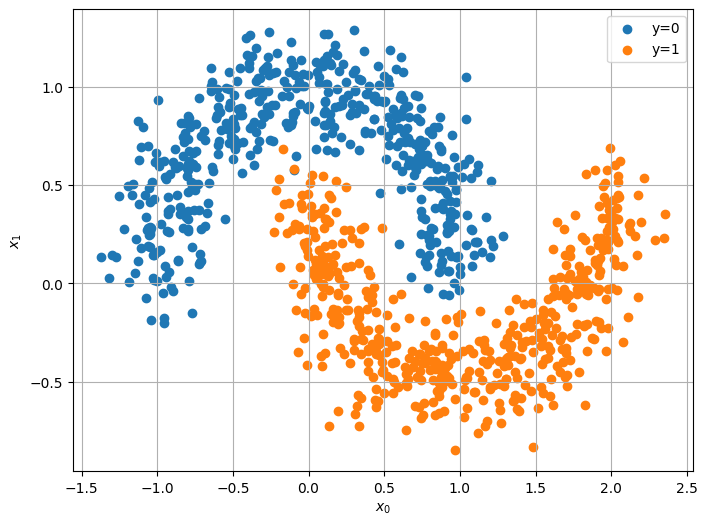

In [9]:
plt.figure(figsize=(8, 6))
plt.scatter(X[y == 0, 0], X[y == 0, 1], label='y=0')
plt.scatter(X[y == 1, 0], X[y == 1, 1], label='y=1')
plt.xlabel('$x_0$')
plt.ylabel('$x_1$')
plt.legend()
plt.grid()

Обучите модели и визуализируйте разделяющую поверхность для обеих моделей с помощью функции plot_separating_surface(). Посчитайте точность (accuracy) на обучающей выборке для каждой из моделей.

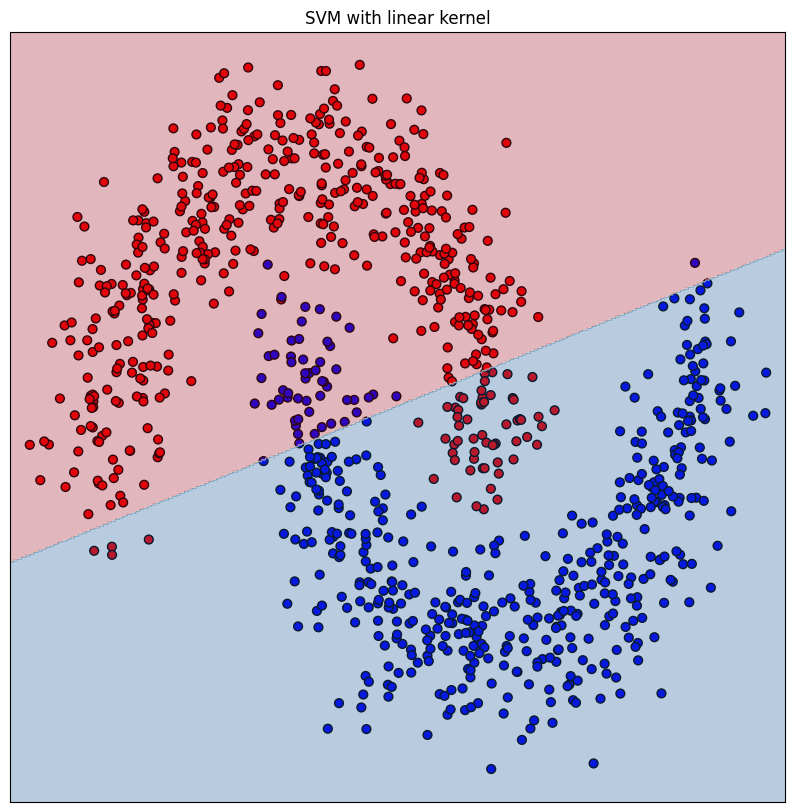

In [10]:
# Обучение модели с линейным ядром
linear_svc.fit(X, y)

# Визуализация разделяющей поверхности
plot_separating_surface(X, y, linear_svc, title="SVM with linear kernel")

In [11]:
print(f'Train Accuracy (linear): {accuracy_score(y, linear_svc.predict(X)):.3f}')

Train Accuracy (linear): 0.885


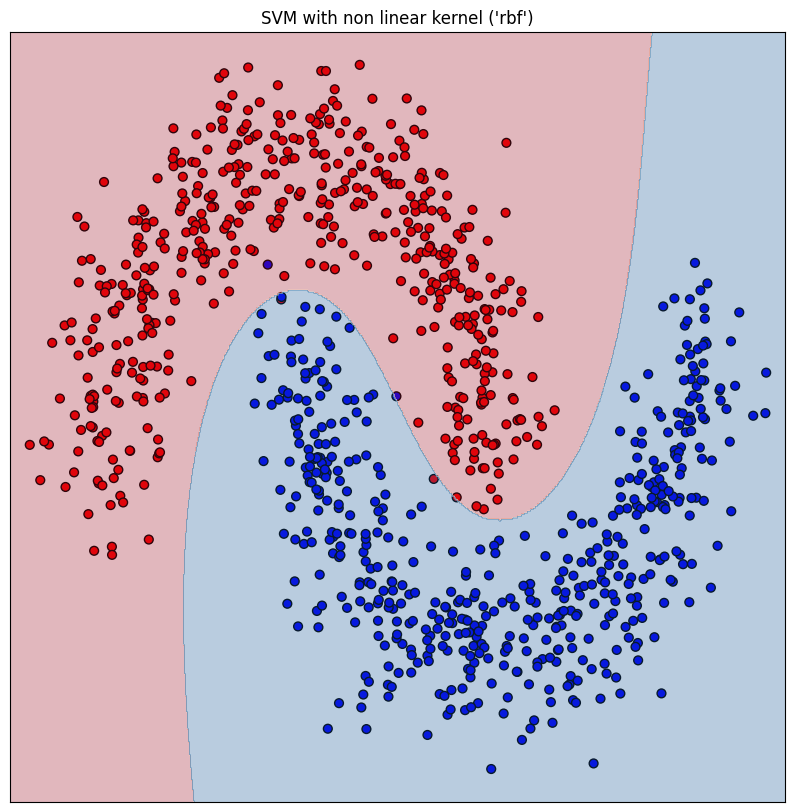

In [12]:
# Обучение модели с нелинейным ядром "rbf"
nonlinear_svc.fit(X, y)

# Визуализация
plot_separating_surface(X, y, nonlinear_svc, title="SVM with non linear kernel ('rbf')")

In [13]:
# Your code here
print(f'Train Accuracy (non linear): {accuracy_score(y, nonlinear_svc.predict(X)):.3f}')

Train Accuracy (non linear): 0.996


**Сделайте вывод**
о получившихся результатах. Какая из моделей лучше подходит для данной выборки и почему?

<font color='MediumOrchid'>**Ваши выводы тут:**</font> Модель с линейным ядром хуже проводит разделяющую поверхность, по графику видно, что значительная часть объектов отнесены к другому классу(**<font color='red'>красные</font>** и **<font color='blue'>cиние</font>** точки). И значение ***accuracy*** $ = 0.862$ также ниже, чем у модели с нелинейным ядром (***accuracy*** $= 0.988$), что говорит о худшем значение точности классификации, что и видно по доле точек на графике.

Модель с нелинейным ядром `rbf` лучше классифицирует объекты, о чем говорит значение accuracy и график, незначительная часть объектов была классифицирована ошибочно, но по сравнению с линейной моделью она классифицировала данные почти идеально.

Это все потому, что ядро `radial basis function` позволяет создать границу принятия решения в виде радиально-симметричного колокола, то есть с помощью окружностей и сфер, что позволяет ей хорошо классифицировать нелинейно разделимые данные. В то время, как линейное ядро проводит линейную границу, что очевидно является не самым эффективным решением при классификации нелинейных данных.

## 2. Опорные объекты

Продолжаем работать с выборкой и моделями из первой части. Для линейной и rbf-моделей рассмотрим
    опорные объекты, полученные после обучения. Визуализировать их можно, используя функуцию plot_separating_surface с параметром vis_support=True. Достанем опорные объекты из обученной модели с помощью поля model.support_.

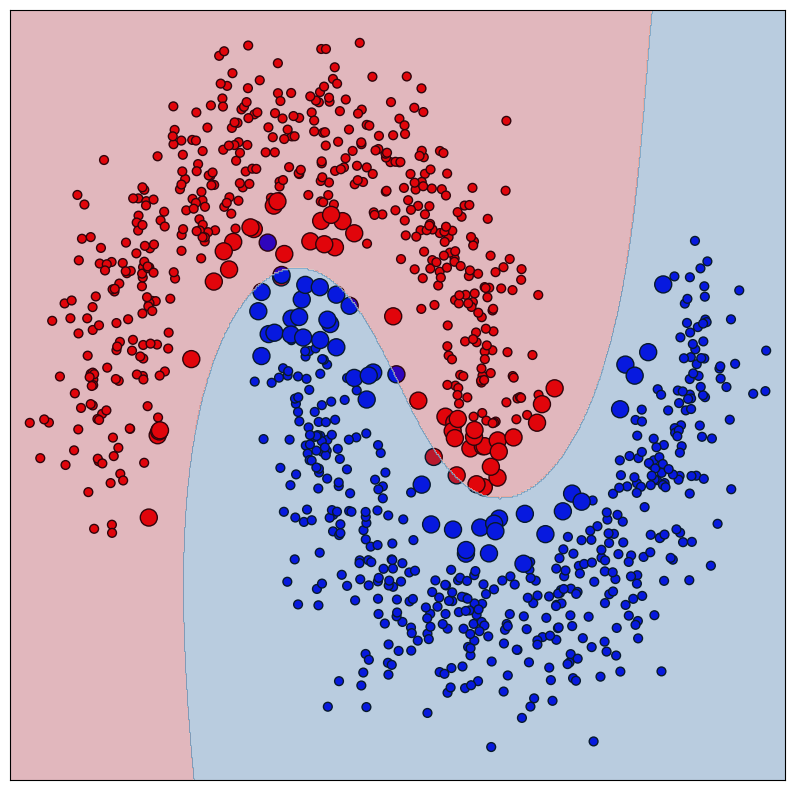

In [14]:
plot_separating_surface(X, y, nonlinear_svc, view_support=True)

Обучим новые две модели $\mbox{SVC(kernel='rbf')}$, используя только опорные объекты построенные с помощью соответственно линейной (linear_svc) и нелинейной (nonlinear_svc) моделей из первой части.

In [15]:
# Учим модели только на опорных объектах
svc_on_linear_support = SVC(kernel='rbf').fit(X[linear_svc.support_, :], y[linear_svc.support_])
svc_on_rbf_support = SVC(kernel='rbf').fit(X[nonlinear_svc.support_, :], y[nonlinear_svc.support_])

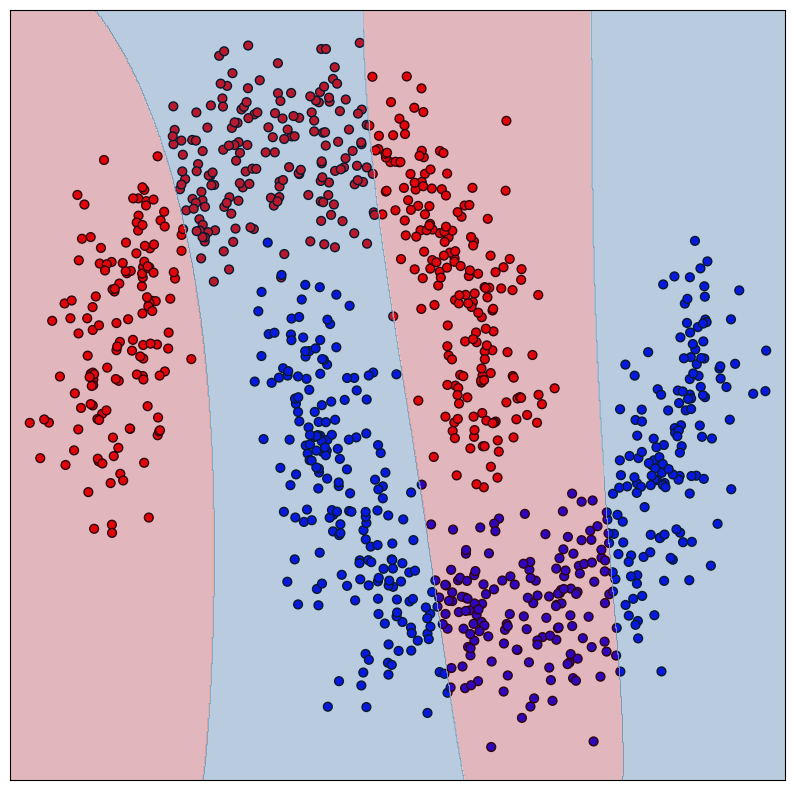

In [16]:
plot_separating_surface(X, y, svc_on_linear_support)

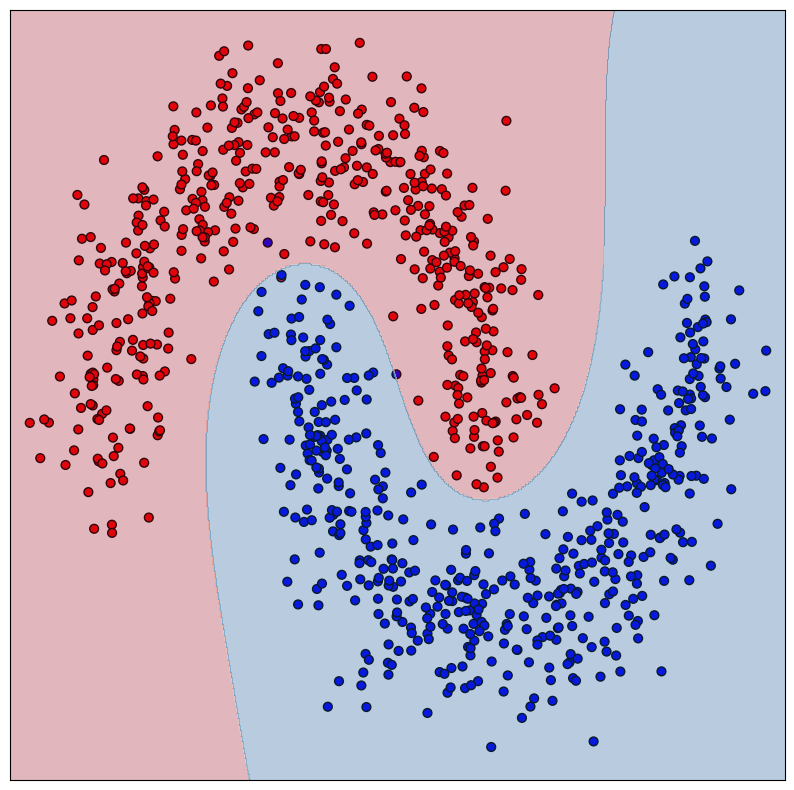

In [17]:
plot_separating_surface(X, y, svc_on_rbf_support)

### <font color='DarkOrange'>**Задание 2 [1 балл]**</font>

Сравните полученные разделяющие поверхности с нелинейной моделью (nonlinear_svc) из задания 1. Какая из поверхностей больше похожа на нелинейнную модель из первой части и почему, опишите в выводе.


<font color='MediumOrchid'>**Ваши выводы тут:**</font> Очевидно, по графику видно, что вторая поверхность `svc_on_rbf_support` больше похоже на нелинейную модль из первой части. Потому что, при обучении модели подается лишь подмножество тех объектов из всех объектов, которые расположены ближе всех к разделяющей гиперплоскости, т.е. **опорных**.

И модель соответственно обучается не на всех данных, а только на этой части объектов, и проводит разделяющую поверхность ближе к этим объектам, поэтому разделяющая поверхность для модели с линейным ядром так плохо провела границу вдоль этих объектов, опорные объекты нелинейно разделимы. А нелинейное ядро очень похожим образом отобразило границу, с небольшим охватом опорных объектов в некоторых местах, поскольку как раз опорные объекты позволяют ей определить нелинейную границу, так как они по сути и являются границей для класса, что собственно показал график.

---

Теперь обучим модель $\mbox{SVC(kernel='rbf')}$, используя все объекты кроме тех, что являлись опорными для нелинейной модели из первой части (nonlinear_svc) и сравним эту модель вместе с svc_on_rbf_support с нелинейной моделью из задания 1(nonlinear_svc). Визуализируйте разделяющие поверхности обеих моделей.

In [18]:
non_support_vectors = [i for i in range(len(X)) if i not in nonlinear_svc.support_]
svc_all_without_rbf_support = SVC(kernel='rbf').fit(X[non_support_vectors, :], y[non_support_vectors])

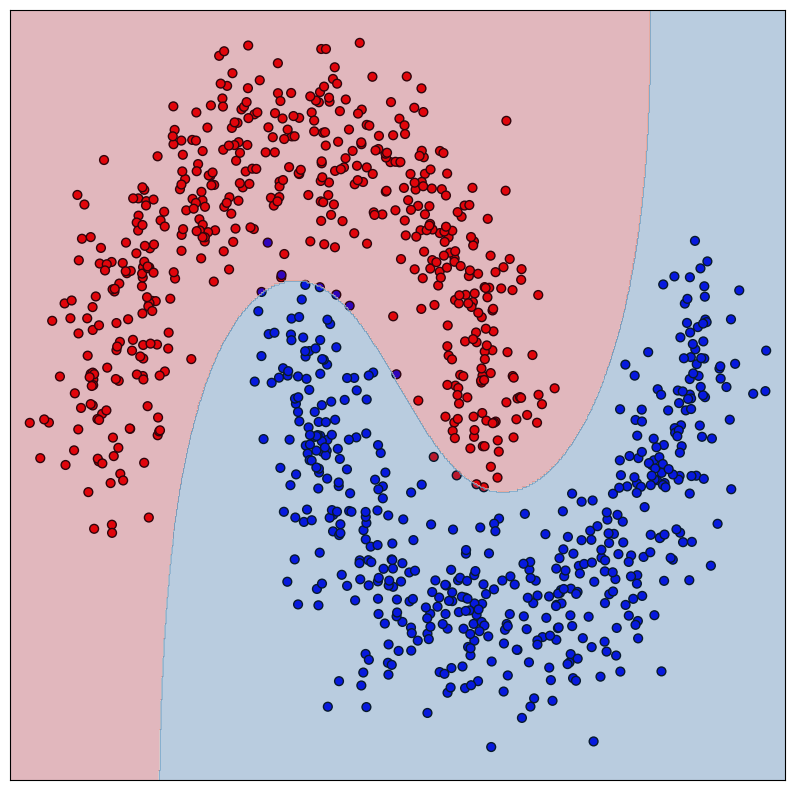

In [19]:
plot_separating_surface(X, y, svc_all_without_rbf_support)

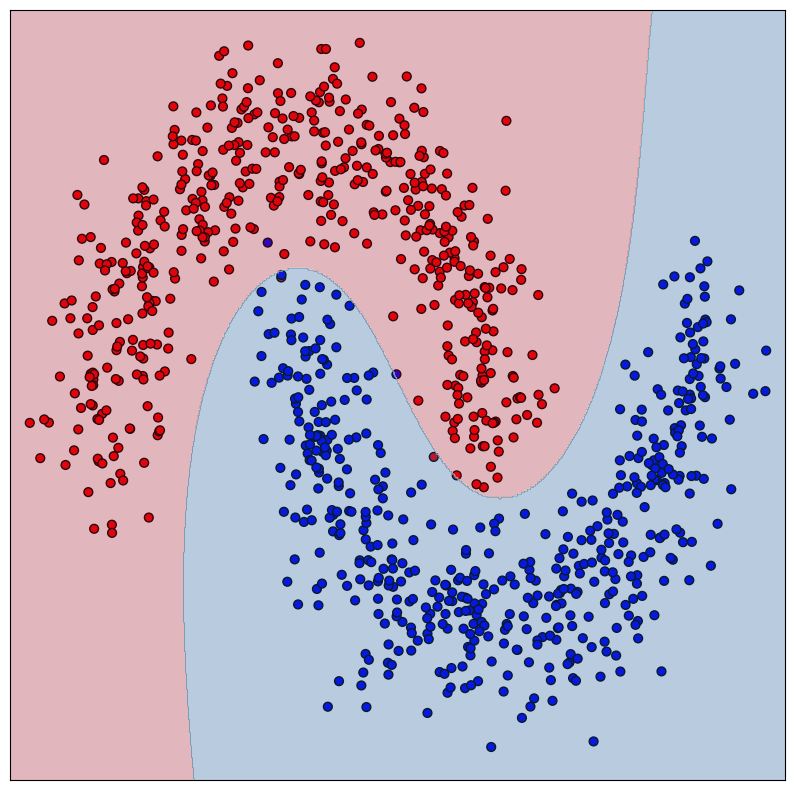

In [20]:
plot_separating_surface(X, y, nonlinear_svc)

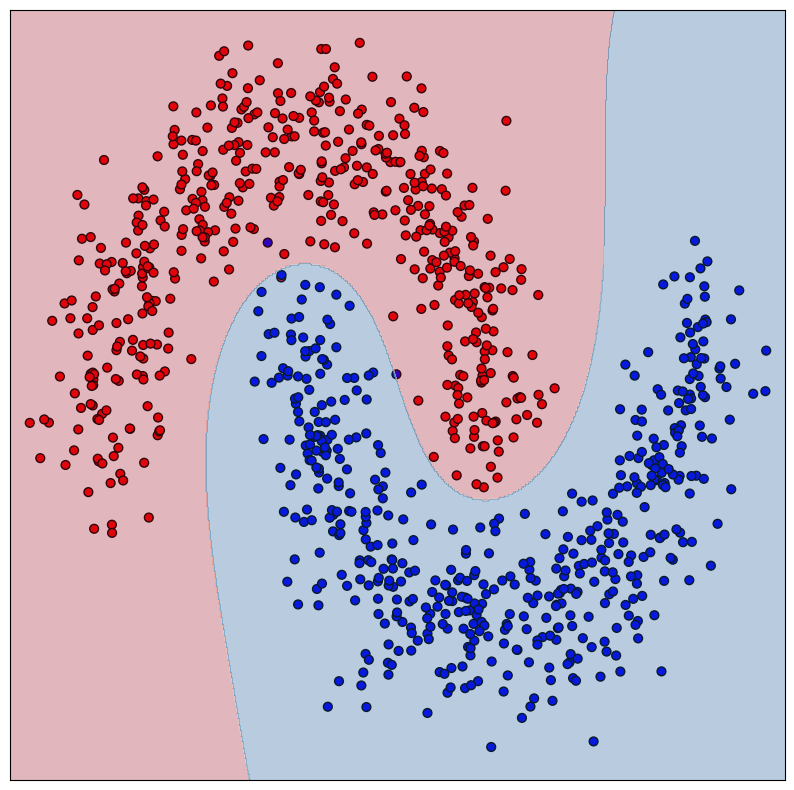

In [21]:
plot_separating_surface(X, y, svc_on_rbf_support)

### <font color='DarkOrange'>**Задание 3 [1.5 баллa]**</font>

**Сделайте вывод:** Сильно ли полученные поверхности отличаются от той, что была получена в первом задании? Что произошло с пограничными объектами? Объясните полученные результаты.

<font color='MediumOrchid'>**Ваши выводы тут:**</font> Поверхности не прям сильно отличаются от той, что была в начале(по сути, это второй график `nonlinear_svc`). Для модели без опорных векторов граница более расширенная, а для модели с только опорными объектами она более суженная, но не значительно.

Видно, что пограничные объекты начинают отходить к своим классам, если в моделе без опорных векторов есть объекты, которые находятся в другом классе, то в модели с только опорными векторами, значительная часть из них уже правильно отнесена к своему классу.

Дело в том, что модель, которая учитывает только опорные объекты начинает балансировать границу на основании всех тех объектов, которые находятся ближе всего к границам класса, поэтому граница получается более суженной к этим объектам, что видно на графике с `svc_on_rbf_support`. Она не учитывает все объекты, из-за чего она подстраивает границу под опорные объекты.

В то время, как нелинейное ядро без опорных векторов, учитывает все объекты, которые являются не опорными, поэтому в учет границы идут все объекты и модель `svc_all_without_rbf_support` выстраивает границу более расширенной, соответственно те объекты, которые находятся на границе начинают попадать в другой класс.

# 4. Обучите лучшую SVM модель (ML-решение)

Возможность строить нелинейные поверхности может сильно улучшить качество, но и несет риск переобучения.
    В этом задании предстоит обучить лучшую svm модель и получить хорошее качество на тесте в системе тестирования. Для контроля переобучения рекомендуется пользоваться кросс-валидацией. Для улучшения качества рекомендуется подбирать

1. параметр регуляризации C;
2. тип разделяющей кривой linear/rbf/poly;
3. степень в случае разделяющей кривой poly.

Также не забывайте, что при решении задач машинного обучения полезно смотреть в данные :)

Все csv-таблицы с данными вы можете взять из публичного теста, который также есть в проверяющей системе. Для этого распакуйте архив с публичными тестами и положите файлы в рабочей директории (рядом с ноутбуком)

In [22]:
X_train = np.load('05-SVM/public/cX_train.npy')
y_train = np.load('05-SVM/public/cy_train.npy')
X_test = np.load('05-SVM/public/cX_test.npy')

In [23]:
X_train.shape, y_train.shape, X_test.shape

((800, 5), (800,), (200, 5))

In [24]:
X = X_train
y = y_train.ravel()

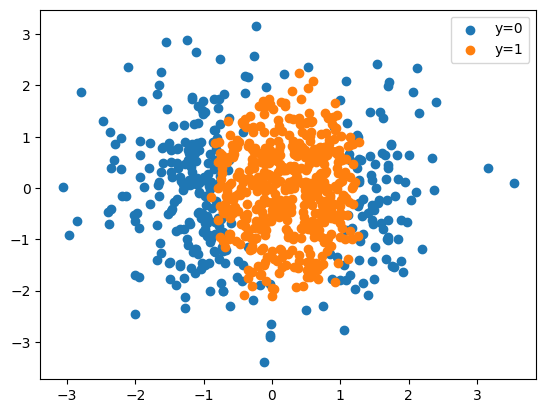

In [25]:
plt.scatter(X[y == 0, 4], X[y == 0, 3], label='y=0')
plt.scatter(X[y == 1, 4], X[y == 1, 3], label='y=1')
plt.legend()

**Отправьте код обучения модели с оптимальными параметрами в проверяющую систему, воспользовавшись приложенным шаблоном svm_solution.py. Кросс-валидацию параметров в посылаемом решении делать <font color='red'>не нужно</font> -- достаточно подобрать, например, их тут, а в решении уже обучать модель с оптимальными параметрами.**

In [177]:
# Сравним как обычный SVC отработает
simple_svc = SVC()

simple_svc.fit(X_train, y_train)

# Выведем состояние модели после нхождения оптимальных гиперпараметров
print(f"Состояние модели: {simple_svc.get_params()}")
print(f'Train Accuracy SVC: {accuracy_score(y_train, simple_svc.predict(X_train)):.3f}')

Состояние модели: {'C': 1.0, 'break_ties': False, 'cache_size': 200, 'class_weight': None, 'coef0': 0.0, 'decision_function_shape': 'ovr', 'degree': 3, 'gamma': 'scale', 'kernel': 'rbf', 'max_iter': -1, 'probability': False, 'random_state': None, 'shrinking': True, 'tol': 0.001, 'verbose': False}
Train Accuracy SVC: 0.955


In [185]:
# Подберем оптимальные гиперпараметры c помощью сетки гиперпараметров GridSearchCV

from sklearn.model_selection import GridSearchCV

C_interval = np.linspace(start=1, stop=10, num=50)

# Определяем сетку гиперпараметров
param_grid = {'C': C_interval,
              'kernel': ['linear', 'rbf'],
              'gamma': [1, 0.1, 0.01, 0.001, 'scale']}

grid_search = GridSearchCV(SVC(), param_grid, refit=True, cv=5, verbose=3)

# Подтягиваем модель к поиску
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 500 candidates, totalling 2500 fits
[CV 1/5] END .....C=1.0, gamma=1, kernel=linear;, score=0.844 total time=   0.0s
[CV 2/5] END .....C=1.0, gamma=1, kernel=linear;, score=0.812 total time=   0.0s
[CV 3/5] END .....C=1.0, gamma=1, kernel=linear;, score=0.825 total time=   0.0s
[CV 4/5] END .....C=1.0, gamma=1, kernel=linear;, score=0.762 total time=   0.0s
[CV 5/5] END .....C=1.0, gamma=1, kernel=linear;, score=0.775 total time=   0.0s
[CV 1/5] END ........C=1.0, gamma=1, kernel=rbf;, score=0.906 total time=   0.1s
[CV 2/5] END ........C=1.0, gamma=1, kernel=rbf;, score=0.875 total time=   0.0s
[CV 3/5] END ........C=1.0, gamma=1, kernel=rbf;, score=0.875 total time=   0.0s
[CV 4/5] END ........C=1.0, gamma=1, kernel=rbf;, score=0.850 total time=   0.0s
[CV 5/5] END ........C=1.0, gamma=1, kernel=rbf;, score=0.912 total time=   0.0s
[CV 1/5] END ...C=1.0, gamma=0.1, kernel=linear;, score=0.844 total time=   0.0s
[CV 2/5] END ...C=1.0, gamma=0.1, kernel=line

GridSearchCV(cv=5, estimator=SVC(),
             param_grid={'C': array([ 1.        ,  1.18367347,  1.36734694,  1.55102041,  1.73469388,
        1.91836735,  2.10204082,  2.28571429,  2.46938776,  2.65306122,
        2.83673469,  3.02040816,  3.20408163,  3.3877551 ,  3.57142857,
        3.75510204,  3.93877551,  4.12244898,  4.30612245,  4.48979592,
        4.67346939,  4.85714286,  5.04081633,  5.2244898 ,  5.40816327,
        5.59183673,  5.7755102 ,  5.95918367,  6.14285714,  6.32653061,
        6.51020408,  6.69387755,  6.87755102,  7.06122449,  7.24489796,
        7.42857143,  7.6122449 ,  7.79591837,  7.97959184,  8.16326531,
        8.34693878,  8.53061224,  8.71428571,  8.89795918,  9.08163265,
        9.26530612,  9.44897959,  9.63265306,  9.81632653, 10.        ]),
                         'gamma': [1, 0.1, 0.01, 0.001, 'scale'],
                         'kernel': ['linear', 'rbf']},
             verbose=3)

In [186]:
# Выведем лучшие гиперпараметры
print(f"Лучшие гиперпараметры модели: \n{grid_search.best_params_}\n")

# Выведем состояние модели после нхождения оптимальных гиперпараметров
print(f"Состояние модели: {grid_search.best_estimator_}")

print(f"Score: {grid_search.best_score_}\n")
print(f'Train Accuracy SVC with best params: {accuracy_score(y_train, grid_search.predict(X_train)):.3f}')

Лучшие гиперпараметры модели: 
{'C': 10.0, 'gamma': 'scale', 'kernel': 'rbf'}

Состояние модели: SVC(C=10.0)
Score: 0.9262500000000001

Train Accuracy SVC with best params: 0.981


# Сравнение с логистической регрессией

#### <font color='DarkOrange'>**Задание 4 [1.5 баллa]**</font>

В предыдущей части Вы обучили хорошую SVM модель, подбирая гиперпараметры модели. Давайте теперь попробуем обучить логистическую регрессию на этой же выборке, и по кросс-валидации оценить влияние гиперпараметров на линейную модель.

In [34]:
from sklearn.linear_model import LogisticRegression

In [52]:
X_train

array([[ 0.11671859, -0.28403176, -0.78284937, -0.33424969,  0.73058647],
       [ 2.40217514, -0.85417342, -0.52933946,  0.90435846, -0.02227596],
       [-0.72708724,  0.30822518,  1.06541911, -0.54679105, -0.9495162 ],
       ...,
       [-0.02657785,  0.02662441,  1.90038116,  0.77197724, -1.60216329],
       [ 0.70314171, -2.14220338,  2.27019464,  0.50768295, -0.25348165],
       [-0.19414599,  1.24983936, -0.8672368 ,  0.94371956,  0.83962266]])

In [158]:
# Обучим сначала логистическую регрессию без подбора гиперпараметров

logreg = LogisticRegression()
logreg.fit(X_train, y_train)

# Выведем параметры
print(f"Параметры модели: \n{logreg.get_params()}\n")
print(f"Score: {logreg.score(X_train, y_train)}")
print(f'Train Accuracy Logisitic Regression: {accuracy_score(y_train, logreg.predict(X_train)):.3f}')

Параметры модели: 
{'C': 1.0, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': None, 'max_iter': 100, 'multi_class': 'auto', 'n_jobs': None, 'penalty': 'l2', 'random_state': None, 'solver': 'lbfgs', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}

Score: 0.79125
Train Accuracy Logisitic Regression: 0.791


In [166]:
# Подберем оптимальные гиперпараметры c помощью сетки гиперпараметров GridSearchCV

# Определяем сетку гиперпараметров
lgr_param_grid = {'penalty': ['l2'],
              'C': np.linspace(1e-5, 10, 100),
              'solver': ['liblinear', 'lbfgs'],
              'max_iter': [200, 300, 500]}

lgr_grid_search = GridSearchCV(LogisticRegression(), lgr_param_grid, refit=True, cv=5, verbose=3)

# Подтягиваем модель к поиску
lgr_grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 600 candidates, totalling 3000 fits
[CV 1/5] END C=1e-05, max_iter=200, penalty=l2, solver=liblinear;, score=0.831 total time=   0.0s
[CV 2/5] END C=1e-05, max_iter=200, penalty=l2, solver=liblinear;, score=0.794 total time=   0.0s
[CV 3/5] END C=1e-05, max_iter=200, penalty=l2, solver=liblinear;, score=0.800 total time=   0.0s
[CV 4/5] END C=1e-05, max_iter=200, penalty=l2, solver=liblinear;, score=0.719 total time=   0.0s
[CV 5/5] END C=1e-05, max_iter=200, penalty=l2, solver=liblinear;, score=0.787 total time=   0.0s
[CV 1/5] END C=1e-05, max_iter=200, penalty=l2, solver=lbfgs;, score=0.606 total time=   0.0s
[CV 2/5] END C=1e-05, max_iter=200, penalty=l2, solver=lbfgs;, score=0.606 total time=   0.0s
[CV 3/5] END C=1e-05, max_iter=200, penalty=l2, solver=lbfgs;, score=0.600 total time=   0.0s
[CV 4/5] END C=1e-05, max_iter=200, penalty=l2, solver=lbfgs;, score=0.600 total time=   0.0s
[CV 5/5] END C=1e-05, max_iter=200, penalty=l2, solver=lbfgs;, score=0

GridSearchCV(cv=5, estimator=LogisticRegression(),
             param_grid={'C': array([1.00000e-05, 1.01020e-01, 2.02030e-01, 3.03040e-01, 4.04050e-01,
       5.05060e-01, 6.06070e-01, 7.07080e-01, 8.08090e-01, 9.09100e-01,
       1.01011e+00, 1.11112e+00, 1.21213e+00, 1.31314e+00, 1.41415e+00,
       1.51516e+00, 1.61617e+00, 1.71718e+00, 1.81819e+00, 1.91920e+00,
       2.02021e+00, 2.12122e+00, 2.22223e+00, 2....
       7.57576e+00, 7.67677e+00, 7.77778e+00, 7.87879e+00, 7.97980e+00,
       8.08081e+00, 8.18182e+00, 8.28283e+00, 8.38384e+00, 8.48485e+00,
       8.58586e+00, 8.68687e+00, 8.78788e+00, 8.88889e+00, 8.98990e+00,
       9.09091e+00, 9.19192e+00, 9.29293e+00, 9.39394e+00, 9.49495e+00,
       9.59596e+00, 9.69697e+00, 9.79798e+00, 9.89899e+00, 1.00000e+01]),
                         'max_iter': [200, 300, 500], 'penalty': ['l2'],
                         'solver': ['liblinear', 'lbfgs']},
             verbose=3)

In [167]:
# Посмотрим на лучшие гиперпараметры и результат

print(f"Лучшие гиперпараметры модели: {lgr_grid_search.best_params_}\n")
print(f"Best Score: {lgr_grid_search.best_score_}\n")
print(f'Train Accuracy Logisitic Regression: {accuracy_score(y_train, lgr_grid_search.predict(X_train)):.3f}')

Лучшие гиперпараметры модели: {'C': 1e-05, 'max_iter': 200, 'penalty': 'l2', 'solver': 'liblinear'}

Best Score: 0.78625

Train Accuracy Logisitic Regression: 0.796


***Дополнительно попробуем преобразовать выборки.***

In [168]:
# Попробуем теперь отнормализовать выборку, сначала в [0, 1], затем стандартно.
from sklearn.preprocessing import MinMaxScaler, StandardScaler

min_max_scaler = MinMaxScaler()
scaler = StandardScaler()

X_train_scaled = min_max_scaler.fit_transform(X_train)
X_scaled = scaler.fit_transform(X_train)

In [169]:
lgr_grid_search.fit(X_train_scaled, y_train)

Fitting 5 folds for each of 600 candidates, totalling 3000 fits
[CV 1/5] END C=1e-05, max_iter=200, penalty=l2, solver=liblinear;, score=0.606 total time=   0.0s
[CV 2/5] END C=1e-05, max_iter=200, penalty=l2, solver=liblinear;, score=0.606 total time=   0.0s
[CV 3/5] END C=1e-05, max_iter=200, penalty=l2, solver=liblinear;, score=0.600 total time=   0.0s
[CV 4/5] END C=1e-05, max_iter=200, penalty=l2, solver=liblinear;, score=0.600 total time=   0.0s
[CV 5/5] END C=1e-05, max_iter=200, penalty=l2, solver=liblinear;, score=0.600 total time=   0.0s
[CV 1/5] END C=1e-05, max_iter=200, penalty=l2, solver=lbfgs;, score=0.606 total time=   0.0s
[CV 2/5] END C=1e-05, max_iter=200, penalty=l2, solver=lbfgs;, score=0.606 total time=   0.0s
[CV 3/5] END C=1e-05, max_iter=200, penalty=l2, solver=lbfgs;, score=0.600 total time=   0.0s
[CV 4/5] END C=1e-05, max_iter=200, penalty=l2, solver=lbfgs;, score=0.600 total time=   0.0s
[CV 5/5] END C=1e-05, max_iter=200, penalty=l2, solver=lbfgs;, score=0

GridSearchCV(cv=5, estimator=LogisticRegression(),
             param_grid={'C': array([1.00000e-05, 1.01020e-01, 2.02030e-01, 3.03040e-01, 4.04050e-01,
       5.05060e-01, 6.06070e-01, 7.07080e-01, 8.08090e-01, 9.09100e-01,
       1.01011e+00, 1.11112e+00, 1.21213e+00, 1.31314e+00, 1.41415e+00,
       1.51516e+00, 1.61617e+00, 1.71718e+00, 1.81819e+00, 1.91920e+00,
       2.02021e+00, 2.12122e+00, 2.22223e+00, 2....
       7.57576e+00, 7.67677e+00, 7.77778e+00, 7.87879e+00, 7.97980e+00,
       8.08081e+00, 8.18182e+00, 8.28283e+00, 8.38384e+00, 8.48485e+00,
       8.58586e+00, 8.68687e+00, 8.78788e+00, 8.88889e+00, 8.98990e+00,
       9.09091e+00, 9.19192e+00, 9.29293e+00, 9.39394e+00, 9.49495e+00,
       9.59596e+00, 9.69697e+00, 9.79798e+00, 9.89899e+00, 1.00000e+01]),
                         'max_iter': [200, 300, 500], 'penalty': ['l2'],
                         'solver': ['liblinear', 'lbfgs']},
             verbose=3)

In [170]:
# Посмотрим на лучшие гиперпараметры и результат

print(f"Лучшие гиперпараметры модели c MinMax нормализацией: {lgr_grid_search.best_params_}\n")
print(f"Best Score: {lgr_grid_search.best_score_}\n")
print(f'Train Accuracy Logistic Regression with MinMax scaling: {accuracy_score(y_train, lgr_grid_search.predict(X_train_scaled)):.3f}')

Лучшие гиперпараметры модели c MinMax нормализацией: {'C': 2.9293, 'max_iter': 200, 'penalty': 'l2', 'solver': 'liblinear'}

Best Score: 0.77875

Train Accuracy Logisitic Regression with MinMax scaling: 0.789


In [171]:
lgr_grid_search.fit(X_scaled, y_train)

Fitting 5 folds for each of 600 candidates, totalling 3000 fits
[CV 1/5] END C=1e-05, max_iter=200, penalty=l2, solver=liblinear;, score=0.806 total time=   0.0s
[CV 2/5] END C=1e-05, max_iter=200, penalty=l2, solver=liblinear;, score=0.787 total time=   0.0s
[CV 3/5] END C=1e-05, max_iter=200, penalty=l2, solver=liblinear;, score=0.794 total time=   0.0s
[CV 4/5] END C=1e-05, max_iter=200, penalty=l2, solver=liblinear;, score=0.719 total time=   0.0s
[CV 5/5] END C=1e-05, max_iter=200, penalty=l2, solver=liblinear;, score=0.787 total time=   0.0s
[CV 1/5] END C=1e-05, max_iter=200, penalty=l2, solver=lbfgs;, score=0.606 total time=   0.0s
[CV 2/5] END C=1e-05, max_iter=200, penalty=l2, solver=lbfgs;, score=0.606 total time=   0.0s
[CV 3/5] END C=1e-05, max_iter=200, penalty=l2, solver=lbfgs;, score=0.600 total time=   0.0s
[CV 4/5] END C=1e-05, max_iter=200, penalty=l2, solver=lbfgs;, score=0.600 total time=   0.0s
[CV 5/5] END C=1e-05, max_iter=200, penalty=l2, solver=lbfgs;, score=0

GridSearchCV(cv=5, estimator=LogisticRegression(),
             param_grid={'C': array([1.00000e-05, 1.01020e-01, 2.02030e-01, 3.03040e-01, 4.04050e-01,
       5.05060e-01, 6.06070e-01, 7.07080e-01, 8.08090e-01, 9.09100e-01,
       1.01011e+00, 1.11112e+00, 1.21213e+00, 1.31314e+00, 1.41415e+00,
       1.51516e+00, 1.61617e+00, 1.71718e+00, 1.81819e+00, 1.91920e+00,
       2.02021e+00, 2.12122e+00, 2.22223e+00, 2....
       7.57576e+00, 7.67677e+00, 7.77778e+00, 7.87879e+00, 7.97980e+00,
       8.08081e+00, 8.18182e+00, 8.28283e+00, 8.38384e+00, 8.48485e+00,
       8.58586e+00, 8.68687e+00, 8.78788e+00, 8.88889e+00, 8.98990e+00,
       9.09091e+00, 9.19192e+00, 9.29293e+00, 9.39394e+00, 9.49495e+00,
       9.59596e+00, 9.69697e+00, 9.79798e+00, 9.89899e+00, 1.00000e+01]),
                         'max_iter': [200, 300, 500], 'penalty': ['l2'],
                         'solver': ['liblinear', 'lbfgs']},
             verbose=3)

In [172]:
# Посмотрим на лучшие гиперпараметры и результат

print(f"Лучшие гиперпараметры модели c стандартной нормализацией: {lgr_grid_search.best_params_}\n")
print(f"Best Score: {lgr_grid_search.best_score_}\n")
print(f'Train Accuracy Logistic Regression: {accuracy_score(y_train, lgr_grid_search.predict(X_scaled)):.3f}')

Лучшие гиперпараметры модели c стандартной нормализацией: {'C': 0.10102, 'max_iter': 200, 'penalty': 'l2', 'solver': 'liblinear'}

Best Score: 0.78125

Train Accuracy Logisitic Regression: 0.791


Сделайте выводы о влиянии выбора гиперпараметров на качество обучения линейной и SVC моделей. Также опишите, какие преобразования выборки/подбор каких гиперпараметров помогли добиться высокого качества на кросс-валидации в данной задаче.

<font color='MediumOrchid'>**Ваши выводы тут:**</font> Как видно из тестов перебор сетки гиперпараметров сыграл свою роль:
* Выбор константы регуляризации для логистической регрессии играет важную роль. Благодаря ей получилось улучшить accuracy с `0.791`($C = 1.0$) до `0.796`($C: 1e-05$)
* В данном случае нормализация данных не принесла значимых результатов.
* Итерации тоже не позволили улучшить качество, я поставил 200 итераций, хотя на самом деле после 100 итераций не происходит заметного изменения.
* Использование разных методов оптимизации существенно для логистической регрессии: `lbfgs` позволил вычислить значение `0.791`, в то время как `liblinear` выдал `0.796`

Для опорных векторов:
* Без подбора гиперпараметров точность получилась `0.955`. После подбора качество выросло до `0.981`.
* Соответственно выбор константы($C$ = `10`) повлиял на улучшение качества. Увеличение итераций до 200 тоже скорее всего улучшило модель.
* Преобразования с данными не дали заметных результатов.

По итогу можно сделать вывод, что при правильном подборе гиперпараметров, качество может значительно увеличиться, что для логистической регрессии, что для SVC модели. SVC модель лучше классифицирует нелинейно разделимые данные, чем логистическая регрессия.

### <font color='MediumSeaGreen'>**Задание 5 [1 балл][Bonus]**</font>

Найдите мем про SVM лучше чем этот:

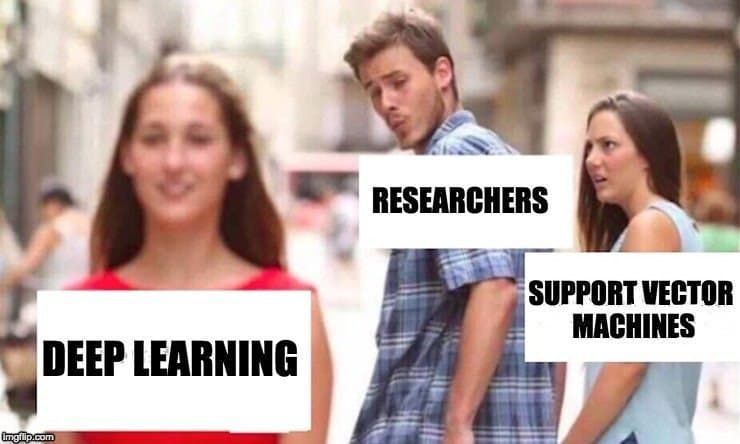

Важно: самый простой способ вставить картинку будет через Google Colab (даже если вы изначально делали не в нем). Нажмите на **"+ Text"**, в появившейся ячейке сделайте **прикрепление картинки** (как на скринах). Тогда ваша картинка "зашифруется" и будет корректно отображаться при конвертации в html

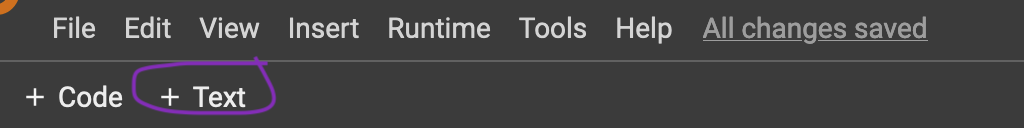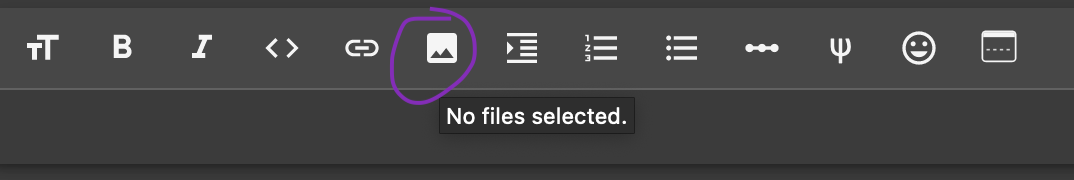

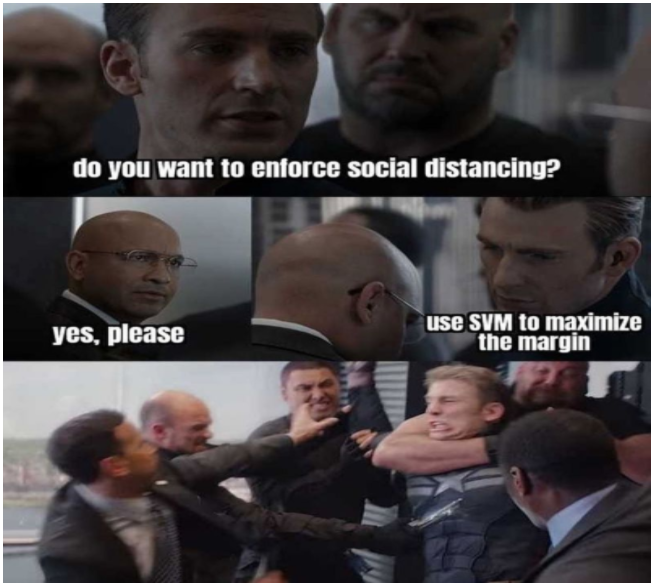